In [1]:
# First, we need to import our libraries

import gc
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Now, let's set up our constant variables

PATH = '/Users/artem/Documents/Projects/CIAN Real Estate Price Prediction/cian-sales-2018-2021.csv'

REGION_ID = 3  # City of Moscow. Let's focus on the main RE market in country

MIN_AREA = 20  # Outlier range for floor area
MAX_AREA = 200

MIN_KITCHEN = 6  # Outlier range for kitchen area
MAX_KITCHEN = 30

MIN_PRICE = 1_500_000  # Outlier range for price
MAX_PRICE = 50_000_000

SEED = 15
N_FOLDS = 5

In [3]:
# Now, let's read our initial dataset

df = pd.read_csv(PATH)
print(f'Data shape: {df.shape}')
df.head()

Data shape: (5477006, 13)


,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [4]:
# What is the columns dtypes?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


In [4]:
# As we know from our EDA, this dataset has no Null values, but has some duplicates
df.duplicated().sum()

1523

In [5]:
# let's drop the duplicates we found
df = df.drop_duplicates()

In [10]:
# basic data exploration in proper format
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)) 

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000
mean,4421478.23207,54.03784,53.24654,4307.44040,1.94903,6.21382,11.39749,1.72621,53.91823,10.62817,3.94383
std,21510157.54730,4.62298,20.74788,3307.99089,1.03857,4.95679,6.53497,1.08214,33.35522,9.79337,4.55765
min,-2144967296.00000,41.45906,19.89020,3.00000,0.00000,1.00000,1.00000,-2.00000,0.07000,0.01000,1.00000
25%,1950000.00000,53.37726,37.77797,2661.00000,1.00000,2.00000,5.00000,1.00000,38.00000,7.00000,1.00000
50%,2990000.00000,55.17128,43.07021,2922.00000,2.00000,5.00000,10.00000,2.00000,48.02000,9.70000,1.00000
75%,4800020.00000,56.22613,65.64969,6171.00000,3.00000,9.00000,16.00000,2.00000,63.13000,12.70000,11.00000
max,2147483647.00000,71.98040,162.53608,61888.00000,5.00000,39.00000,39.00000,10.00000,7856.00000,9999.00000,11.00000


In [ ]:
# Ok, now we need to clean the dataset using the same functions and steps that we used in EDA.
# I intentionally pre-process again the dataset from the beginning in this notebook

In [6]:
# Function removes excess columns and enforces correct data types. 
# :param df: Original DataFrame :return: Updated DataFrame
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df.drop('time', axis=1, inplace=True)
    # Date to Datetime
    df['date'] = pd.to_datetime(df['date'])
    # Column actually contains -1 and -2 values presumably for studio apartments.
    df['rooms'] = df['rooms'].apply(lambda x: 0 if x < 0 else x)
    df['price'] = df['price'].abs()  # Fix negative values
    # Drop price and area outliers.
    df = df[(df['area'] <= MAX_AREA) & (df['area'] >= MIN_AREA)]
    df = df[(df['price'] <= MAX_PRICE) & (df['price'] >= MIN_PRICE)]
    # Fix kitchen area outliers.
    # At first, replace all outliers with 0.
    df.loc[(df['kitchen_area'] >= MAX_KITCHEN) | (df['area'] <= MIN_AREA), 'kitchen_area'] = 0
    # Then calculate kitchen area based on the floor area, except for studios.
    erea_mean, kitchen_mean = df[['area', 'kitchen_area']].quantile(0.5)
    kitchen_share = kitchen_mean / erea_mean
    df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'kitchen_area'] = \
        df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'area'] * kitchen_share
    # convert prices to Millions
    df['price'] = df['price']/1_000_000
    
    return df

In [7]:
# Function selects the listings belonging to a specified region.
#    :param df: Original DataFrame with all listings
#    :return: Filtered DataFrame
def select_region(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df['region'] == REGION_ID]
    df.drop('region', axis=1, inplace=True)
    print(f'Selected {len(df)} samples in region {REGION_ID}.')
    return df

In [8]:
# let's clean our dataset and preview it
df = df.pipe(clean_data)
df

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6.05000,2018-02-19,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8.65000,2018-02-27,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4.00000,2018-02-28,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1.85000,2018-03-01,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5.45000,2018-03-01,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5477001,19.73976,2021-05-01,55.804736,37.750898,3,1,8,17,4,93.2,13.8,11
5477002,12.50316,2021-05-01,55.841415,37.489624,3,2,17,32,2,45.9,6.6,11
5477003,8.80000,2021-05-01,56.283909,44.075408,2871,2,4,17,3,86.5,11.8,1
5477004,11.83191,2021-05-01,55.804736,37.750898,3,1,8,33,2,52.1,18.9,11


In [9]:
# and filter out only Moscow city sales for our ML model
df = df.pipe(select_region)
df

Selected 410798 samples in region 3.


,price,date,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type
6,4.70428,2018-03-04,55.621097,37.431002,2,1,25,1,31.7,6.0,11
20,8.00000,2018-03-17,55.738876,37.825370,1,5,9,2,45.0,6.0,1
29,11.50000,2018-04-03,55.798921,37.738090,1,14,16,3,64.9,8.0,1
34,10.20000,2018-04-07,55.655307,37.614605,2,7,14,2,52.8,10.0,1
44,11.50000,2018-04-18,55.701330,37.507412,1,14,17,1,42.0,12.0,1
...,...,...,...,...,...,...,...,...,...,...,...
5476999,12.85000,2021-05-01,55.701280,37.642654,2,12,24,1,41.0,9.0,1
5477001,19.73976,2021-05-01,55.804736,37.750898,1,8,17,4,93.2,13.8,11
5477002,12.50316,2021-05-01,55.841415,37.489624,2,17,32,2,45.9,6.6,11
5477004,11.83191,2021-05-01,55.804736,37.750898,1,8,33,2,52.1,18.9,11


In [ ]:
# Now we can play with the additional features for our dataset.
# Year and Month could be potential factors to reflect seasonality in sales
# Level-to-levels is another feature to consider (how hight the apartment in the building)
# Average size of room in the apartment.
# There is a room to design additional features and test the metrics with them

In [10]:
# add features
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    # Replace "date" with numeric features for year and month.
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df.drop('date', axis=1, inplace=True)
    # Apartment floor in relation to total number of floors.
    df['level_to_levels'] = df['level'] / df['levels']
    # Average size of room in the apartment.
    df['area_to_rooms'] = (df['area'] / df['rooms']).abs()
    # Fix division by zero.
    df.loc[df['area_to_rooms'] == np.inf, 'area_to_rooms'] = \
        df.loc[df['area_to_rooms'] == np.inf, 'area']
    return df

In [11]:
# Let's apply our add_features function to the dataset
df = df.pipe(add_features)
df

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
6,4.70428,55.621097,37.431002,2,1,25,1,31.7,6.0,11,2018,3,0.040000,31.700000
20,8.00000,55.738876,37.825370,1,5,9,2,45.0,6.0,1,2018,3,0.555556,22.500000
29,11.50000,55.798921,37.738090,1,14,16,3,64.9,8.0,1,2018,4,0.875000,21.633333
34,10.20000,55.655307,37.614605,2,7,14,2,52.8,10.0,1,2018,4,0.500000,26.400000
44,11.50000,55.701330,37.507412,1,14,17,1,42.0,12.0,1,2018,4,0.823529,42.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476999,12.85000,55.701280,37.642654,2,12,24,1,41.0,9.0,1,2021,5,0.500000,41.000000
5477001,19.73976,55.804736,37.750898,1,8,17,4,93.2,13.8,11,2021,5,0.470588,23.300000
5477002,12.50316,55.841415,37.489624,2,17,32,2,45.9,6.6,11,2021,5,0.531250,22.950000
5477004,11.83191,55.804736,37.750898,1,8,33,2,52.1,18.9,11,2021,5,0.242424,26.050000


In [12]:
# Ok, now the dataset looks good for modeling.
# For the purity of our experiment, let's set a fixed random generation

def set_seed(seed=123):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    # tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(SEED)

In [13]:
# Now we can separate target (price)
y = df.pop('price')
y

6           4.70428
20          8.00000
29         11.50000
34         10.20000
44         11.50000
             ...   
5476999    12.85000
5477001    19.73976
5477002    12.50316
5477004    11.83191
5477005    13.31620
Name: price, Length: 410798, dtype: float64

In [14]:
# from predictors (variables)
X = df
X

,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
6,55.621097,37.431002,2,1,25,1,31.7,6.0,11,2018,3,0.040000,31.700000
20,55.738876,37.825370,1,5,9,2,45.0,6.0,1,2018,3,0.555556,22.500000
29,55.798921,37.738090,1,14,16,3,64.9,8.0,1,2018,4,0.875000,21.633333
34,55.655307,37.614605,2,7,14,2,52.8,10.0,1,2018,4,0.500000,26.400000
44,55.701330,37.507412,1,14,17,1,42.0,12.0,1,2018,4,0.823529,42.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476999,55.701280,37.642654,2,12,24,1,41.0,9.0,1,2021,5,0.500000,41.000000
5477001,55.804736,37.750898,1,8,17,4,93.2,13.8,11,2021,5,0.470588,23.300000
5477002,55.841415,37.489624,2,17,32,2,45.9,6.6,11,2021,5,0.531250,22.950000
5477004,55.804736,37.750898,1,8,33,2,52.1,18.9,11,2021,5,0.242424,26.050000


In [15]:
# Now we can split train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [16]:
X_train

,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
2040263,55.881585,37.683930,2,3,21,2,55.3,13.1,11,2019,6,0.142857,27.65
3099419,55.568089,37.569701,1,4,16,1,35.0,11.0,1,2019,12,0.250000,35.00
4139988,55.753639,37.700671,2,18,27,3,78.0,14.7,11,2020,7,0.666667,26.00
3399782,55.860423,37.541063,2,9,23,1,33.6,10.7,11,2020,3,0.391304,33.60
1195738,55.579910,37.679343,1,3,9,1,33.0,6.0,1,2019,2,0.333333,33.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624622,55.789879,37.452961,2,9,22,1,51.0,10.0,11,2019,4,0.409091,51.00
2738077,55.701607,37.932476,1,5,5,2,54.0,14.0,1,2019,10,1.000000,27.00
2951962,55.676582,37.694148,1,2,12,1,38.6,9.0,1,2019,11,0.166667,38.60
3988680,55.722482,37.774804,2,4,33,4,97.0,6.1,11,2020,6,0.121212,24.25


In [53]:
# Let's try XGBRegressor and RandomForestRegressor with basic parameters and StandardScaler() pipeline

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

# Declare data preprocessing steps
model1 = RandomForestRegressor(n_estimators=100, random_state=SEED)
model2 = XGBRegressor(n_estimators=100, random_state=SEED)

pipeline = make_pipeline(preprocessing.StandardScaler(), model2)

# Declare hyperparameters to tune
hyperparameters1 = {
                    'randomforestregressor__max_features' : ['auto'], 
                    'randomforestregressor__max_depth': [5],
                    'randomforestregressor__max_leaf_nodes': [100]
                   }

hyperparameters2 = {
                    'xgbregressor__max_features' : ['auto'], 
                    'xgbregressor__max_depth': [5],
                    'xgbregressor__max_leaf_nodes': [100]
                   }

# Tune model using cross-validation pipeline
model = GridSearchCV(pipeline, hyperparameters2, cv=5)
model.fit(X_train, y_train)

# Evaluate model pipeline on test data
pred = model.predict(X_test)

print( mean_absolute_error(y_test, pred))
print( model.score(X_test, y_test) )


[11:28:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "max_features", "max_leaf_nodes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:28:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "max_features", "max_leaf_nodes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:28:39] WARNING: /Users/runner/work/xgboost

In [72]:
# Another aproach with XGRegressor with KFold without scaling

from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib


kf = KFold(N_FOLDS, shuffle=True, random_state=SEED)

scores = []

for train_index, test_index in kf.split(X, y):

    x_train, x_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_xgb = XGBRegressor(objective='reg:squarederror')

    model_xgb.fit(x_train, y_train, eval_set=[(x_test, y_test)],
                  eval_metric='rmse', early_stopping_rounds=50,
                  verbose=0)

    scores.append(model_xgb.best_score)
    model_xgb.save_model(f'xgboost{len(scores)}.bin')


#print('XGBoost average RMSE:', np.mean(round(scores,2)))

pred = model_xgb.predict(x_test)

print( mean_absolute_error(y_test, pred))
print( model_xgb.score(x_test, y_test) )


#for i, score in enumerate(scores):
#    print(f'Model {i} RMSE: {round(score,2)}')

1.3304469656994313
0.8834797185967858


In [17]:
# Approach with implicit features encoding (num/cat/relevance)

numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in X.columns if X[col].nunique() < 50 and X[col].dtype == "object"]

#object_cols = [col for col in train_data.columns if train_data[col].dtype == "object"]
#cols_with_missing = [col for col in train_data.columns if train_data[col].isnull().any()]

X_train = X_train[numerical_cols+categorical_cols]
X_test = X_test[numerical_cols+categorical_cols]


In [18]:
X_test

,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
2337105,55.886918,37.534136,2,12,33,1,38.0,18.7,11,2019,8,0.363636,38.000000
1376591,55.673621,37.745466,2,9,15,1,33.0,10.0,11,2019,3,0.600000,33.000000
1333599,55.924845,37.548546,2,11,14,2,63.0,14.0,1,2019,3,0.785714,31.500000
2817603,55.754047,37.620405,2,2,21,1,33.0,6.0,1,2019,10,0.095238,33.000000
4127635,55.678707,37.634631,2,14,28,3,72.6,16.2,1,2020,7,0.500000,24.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695774,55.748212,37.400678,1,1,9,2,46.0,6.0,1,2019,10,0.111111,23.000000
5001578,55.753886,37.524664,2,14,30,1,30.0,5.0,1,2021,2,0.466667,30.000000
3434580,55.681280,37.646363,1,2,9,1,32.4,7.0,1,2020,3,0.222222,32.400000
1391689,55.662770,37.515316,2,2,20,3,112.0,20.0,1,2019,3,0.100000,37.333333


In [20]:
# Transformation pipeline approach with Random Forest Regressor and XGBRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Define model
model1 = RandomForestRegressor(n_estimators=100, random_state=123)
model2 = XGBRegressor(n_estimators=50, random_state=123)


# Bundle preprocessing and modeling code in a pipeline
model_pip = Pipeline(steps=[
                            ('preprocessor', preprocessor),
                            ('model', model1)
                            ])

# Preprocessing of training data, fit model 
model_pip.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = model_pip.predict(X_test)


print('MAE:', mean_absolute_error(y_test, preds))
print('Model score:', model_pip.score(X_test, y_test))


MAE: 0.9270391285173525
Model score: 0.9168472398993619


In [22]:
# RandomForestRegressor model with transformation pipeline (encoding) showing the promising 91.7% accuracy score
# even with basic parameters
# Let's run our model_pip though Cross Validation on entire dataset to find out more realistic score

from sklearn.model_selection import cross_val_score
result_final = cross_val_score(model_pip, X, y, cv=5, scoring='accuracy')

print(np.mean(result_final))
print(np.std(result_final))

0.8567433238011939
0.027104966088768025


In [ ]:
# Ok, so it looks like RandomForestRegressor model with transformation pipeline by now is the best model
# It is the slowest model that give us fair 85.67% accuracy with STD +/- 2.7%. 
# There were no signs of underfitting or overfitting throughout the process.

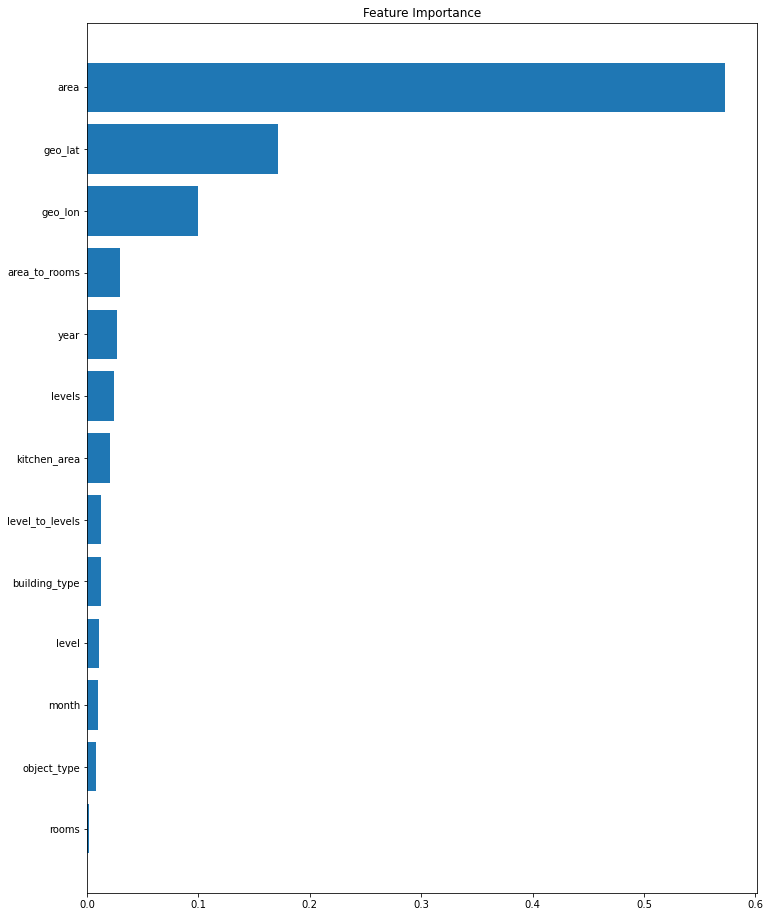

In [24]:
# Now lets see the feature importance according to our underlying model1 (model_pip without pipeline)

import matplotlib.pyplot as plt

# Display feature importance.
importance = pd.DataFrame({
    'features': X.columns,
    'importance': model1.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('Feature Importance')
plt.show()

In [ ]:
# Obviously total_area and geographic coordinates (district) are the most important features
# There is a lot possible to do to acheive better speed and accuracy
# Additional data is highly required for weightened aproach to price prediction

In [34]:
# Safe the model

import joblib

filename = 'model_pip.sav'
joblib.dump(model_pip, filename)

['model_pip.sav']

In [35]:
# load the model from disk

loaded_model = joblib.load(filename)
loaded_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['geo_lat', 'geo_lon',
                                                   'building_type', 'level',
                                                   'levels', 'rooms', 'area',
                                                   'kitchen_area',
                                                   'object_type', 'year',
                                                   'month', 'level_to_levels',
                                                   'area_to_rooms']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                      